In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import interpolate

from astropy import constants as const
from astropy import units as u

rc_params = {
    'lines.linewidth': 2,  # Set line width to 2 points
    'font.family': 'STIXGeneral',  # Set color cycle for axes
    'ytick.direction': 'in',  # Set figure size in inches
    'xtick.direction': 'in',  # Set default font family
}

plt.rcParams.update(rc_params)

In [2]:
spectra_metadata = pd.read_csv('wiserep_spectra_metadata.csv')
spectra_metadata.columns

/tmp/ipykernel_4133/3985640640.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  spectra_metadata = pd.read_csv('wiserep_spectra_metadata.csv')


Index(['Obj. ID', 'IAU name', 'Internal name/s', 'Obj. RA', 'Obj. DEC',
       'Obj. Type', 'Redshift', 'Spec. ID', 'Obs-date', 'JD', 'Phase (days)',
       'From', 'Telescope', 'Instrument', 'Observer/s', 'Reducer/s',
       'Source group', 'Public', 'Associated groups', 'End prop. period',
       'Ascii file', 'Fits file', 'Spec. type', 'Spec. quality',
       'Extinction-Corrected', 'WL Medium', 'WL Units',
       'Flux Unit Coefficient', 'Spec. units', 'Flux Calibrated By',
       'Exp-time', 'Aperture (slit)', 'HA', 'Airmass', 'Dichroic', 'Grism',
       'Grating', 'Blaze', 'Lambda-min', 'Lambda-max', 'Del-Lambda', 'Contrib',
       'Publish', 'Remarks', 'Created by', 'Creation date'],
      dtype='object')

In [34]:
spectra_metadata['Spec. units']

0                             Other
1                             Other
2                             Other
3                             Other
4                             Other
                    ...            
46446                         Other
46447    erg cm(-2) sec(-1) Ang(-1)
46448                         Other
46449    erg cm(-2) sec(-1) Ang(-1)
46450    erg cm(-2) sec(-1) Ang(-1)
Name: Spec. units, Length: 46451, dtype: object

In [2]:
spectra_data = pd.read_pickle('spectra_ALeRCE20240630_x_wisrep_20240622.pkl')
spectra_data.head()

,oid,snname,instrument,mjd,lambda_grid_min,lambda_grid_max,nlambda_grid,lambda_data_min,lambda_data_max,flux_lambda,e_flux_lambda
0,NaN,SN2021aefs,ESO-NTT,59560.313577,3206.34,10915.01,1838,3651.341553,9244.899935,"[1.91091e-16, 1.82705e-16, 1.97729e-16, 1.8812...","[7.185204317077444e-18, 1.5696079042524182e-17..."
1,NaN,SN2021aefs,P60,59559.436690,3206.34,10915.01,1838,3651.341553,9244.899935,"[1.91091e-16, 1.82705e-16, 1.97729e-16, 1.8812...","[7.185204317077444e-18, 1.5696079042524182e-17..."
2,ZTF20aburywx,SN2020rsc,Keck1,59226.000000,3206.34,10915.01,1838,3077.048800,10304.617000,"[2.03112e-16, 2.94057e-16, 2.56117e-16, 3.6180...","[5.4224405104354494e-17, 5.302190662866851e-17..."
3,NaN,SN2011kg,HST,55943.000000,3206.34,10915.01,1838,1903.618857,10615.877400,"[0.2298616, 0.1718295, 0.1137441, 0.0555966, -...","[0.0374385692592133, 0.03915660996486737, 0.04..."
4,NaN,SN2011kg,Keck1,55926.000000,3206.34,10915.01,1838,1903.618857,10615.877400,"[0.2298616, 0.1718295, 0.1137441, 0.0555966, -...","[0.0374385692592133, 0.03915660996486737, 0.04..."


In [3]:
spectrum = spectra_data[spectra_data.snname == 'SN2020ifc']
spectrum

,oid,snname,instrument,mjd,lambda_grid_min,lambda_grid_max,nlambda_grid,lambda_data_min,lambda_data_max,flux_lambda,e_flux_lambda
20,ZTF20aauodrj,SN2020ifc,P60,58965.475625,3206.34,10915.01,1838,3776.7,9223.3,"[2.751e-17, 2.751e-17, -2.089e-17, -2.089e-17,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
21,ZTF20aauodrj,SN2020ifc,P60,58965.475625,3206.34,10915.01,1838,3776.7,9223.3,"[2.751e-17, 2.751e-17, -2.089e-17, -2.089e-17,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [4]:
spectrum_test = spectrum.iloc[0]
spectrum_test

oid                                                     ZTF20aauodrj
snname                                                     SN2020ifc
instrument                                                       P60
mjd                                                     58965.475625
lambda_grid_min                                              3206.34
lambda_grid_max                                             10915.01
nlambda_grid                                                    1838
lambda_data_min                                               3776.7
lambda_data_max                                               9223.3
flux_lambda        [2.751e-17, 2.751e-17, -2.089e-17, -2.089e-17,...
e_flux_lambda      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 20, dtype: object

In [44]:
wavelength_lsst = {
    'u': [3206.34, 4081.51],
    'g': [3876.02, 5665.33],
    'r': [5377.19, 7055.16],
    'i': [6765.77, 8325.05],
    'z': [8035.39, 9375.47],
    'y': [9089.07, 10915.01],
}

wavelength_ztf ={
    'g' : [3676.00, 5613.82],
    'r' : [5497.60, 7394.40],
    'i' : [6870.97, 8964.61],
}

In [8]:
lambda_grid = np.logspace(start=np.log10(spectrum_test.lambda_grid_min),
                stop=np.log10(spectrum_test.lambda_grid_max),
                num=spectrum_test.nlambda_grid)

flux = np.array(eval(spectrum_test.flux_lambda))
lambda_data = np.logspace(start=np.log10(spectrum_test.lambda_data_min),
                stop=np.log10(spectrum_test.lambda_data_max),
                num=len(flux))

f = interpolate.interp1d(lambda_data, flux, fill_value=np.nan, bounds_error=False)
flux_new = f(lambda_grid)
flux_new

array([nan, nan, nan, ..., nan, nan, nan])

In [56]:
print(const.L_sun.cgs/(4*np.pi*1*u.au.to('cm')**2))

1361166.4654085755 erg / s


In [26]:
def simpler_intergrate(x:list[float],y:list[float]) -> float:
    
    y = np.nan_to_num(y, nan=0.0)
    
    integral = 0
    
    LSUN = const.L_sun

    for i in range(1,len(x)):
        delta_x = x[i] - x[i-1]
        integral += y[i-1] * delta_x

    return integral

In [29]:
condition = np.where((wavelength_ztf['r'][0] < lambda_grid) & (wa4 * u.pi *velength_ztf['r'][1] > lambda_grid))
x_g = lambda_grid[condition]
y_g = flux_new[condition]
test = simpler_intergrate(x_g, y_g)
test

1.0423962861092995e-13

Text(0, 0.5, 'Luminosity [erg cm**-2 s**-1]')

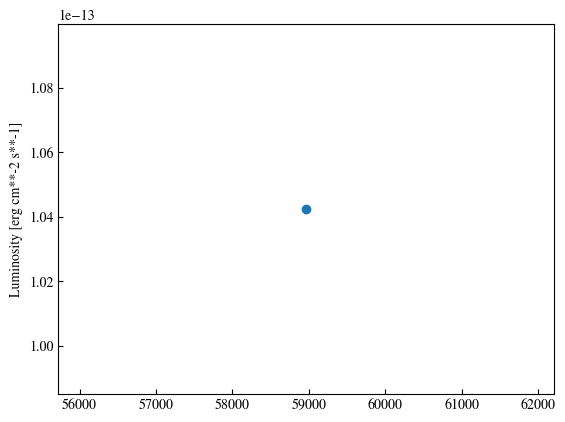

In [43]:
fig, ax = plt.subplots()
ax.scatter(spectrum_test.mjd,test)
ax.set_ylabel('Luminosity [erg cm**-2 s**-1]')

In [ ]:
luminosity_g, luminosity_i = [], []

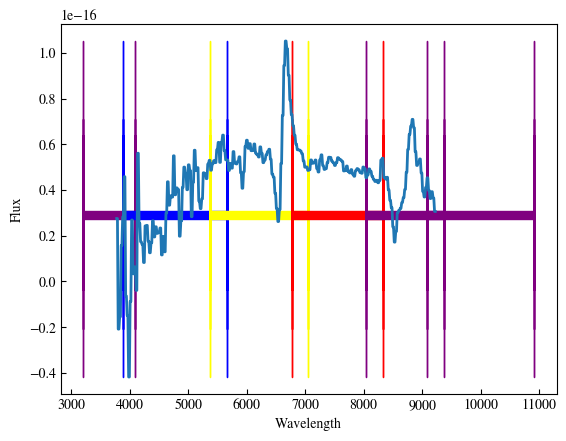

In [91]:
x = np.linspace(spectrum_test.lambda_data_min,spectrum_test.lambda_data_max, len(eval(spectrum_test.flux_lambda)))
y = eval(spectrum_test.flux_lambda)

fig, ax = plt.subplots()
#y = eval(group.flux_lambda)
ax.plot(x, np.array(y))
ax.set_ylabel('Flux')
ax.set_xlabel('Wavelength')
ax.fill_betweenx(y=y,x1=wavelength_lsst['u'][0],x2=wavelength_lsst['u'][1],color='purple')
ax.fill_betweenx(y=y,x1=wavelength_lsst['g'][0],x2=wavelength_lsst['g'][1],color='blue')
ax.fill_betweenx(y=y,x1=wavelength_lsst['r'][0],x2=wavelength_lsst['r'][1],color='yellow')
ax.fill_betweenx(y=y,x1=wavelength_lsst['i'][0],x2=wavelength_lsst['i'][1],color='red')
ax.fill_betweenx(y=y,x1=wavelength_lsst['z'][0],x2=wavelength_lsst['z'][1],color='purple')
ax.fill_betweenx(y=y,x1=wavelength_lsst['y'][0],x2=wavelength_lsst['y'][1],color='purple')

In [105]:
len(y),len(x)


(428, 428)

In [107]:
I = integrate.simpson(y[condicion],x[condicion])
I

5.873091314722876e-14

['[2.751e-17, 2.751e-17, -2.089e-17, -2.089e-17, -1.548e-17, -1.548e-17, 1.572e-17, 1.572e-17, 2.824e-17, 2.824e-17, 4.583e-17, 4.583e-17, -6.369e-18, -6.369e-18, -1.49e-17, -1.49e-17, -4.186e-17, -4.186e-17, -8.85e-18, -8.85e-18, 2.686e-17, 2.686e-17, 3.301e-18, 3.301e-18, 6.311e-18, 6.311e-18, -3.95e-18, -3.95e-18, 5.609e-17, 5.609e-17, 2.54e-17, 2.54e-17, 1.735e-17, 1.735e-17, 1.614e-17, 1.614e-17, 8.248e-18, 8.248e-18, 2.429e-17, 2.429e-17, 2.452e-17, 2.452e-17, 1.761e-17, 1.761e-17, 1.251e-17, 1.251e-17, 1.686e-17, 1.686e-17, 2.653e-17, 2.653e-17, 1.944e-17, 1.944e-17, 2.39e-17, 2.39e-17, 2.102e-17, 2.102e-17, 2.14e-17, 2.14e-17, 2.337e-17, 2.337e-17, 1.157e-17, 1.157e-17, 1.969e-17, 1.969e-17, 1.293e-17, 1.293e-17, 2.989e-17, 2.989e-17, 4.36e-17, 4.36e-17, 3.334e-17, 3.334e-17, 3.748e-17, 3.748e-17, 3.688e-17, 3.688e-17, 5.497e-17, 5.497e-17, 3.79e-17, 3.79e-17, 4.091e-17, 4.091e-17, 4.021e-17, 4.021e-17, 1.977e-17, 1.977e-17, 2.648e-17, 2.648e-17, 4.114e-17, 4.114e-17, 5.002e-17

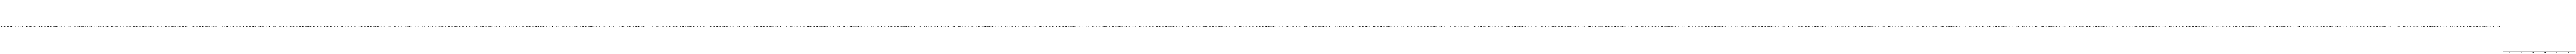

In [41]:
fig, ax = plt.subplots(figsize=(10,7))
for mjd_indt, group in spectrum.groupby('mjd'):
    y = group.flux_lambda.values
    print(y)
    print(len(y))
    print(y.dtype)
    x = np.linspace(group.lambda_data_min.iloc[0],group.lambda_data_max.iloc[0], len(y))
    print(x)
    #y = eval(group.flux_lambda)
    ax.plot(x, np.array(y))
    